In [475]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network


In [476]:
# Load FEAST output file
file_path = '../feast_analysis/data/strep_oral-source_source_contributions_matrix.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)
df.head()

,S186_28_oral,S190_29_oral,S195_30_oral,S197_31_oral,S210_33_oral,S213_34_oral,S217_35_oral,Unknown
S184_28_cheek,0.263831,1.023448e-08,0.091629,0.004946,0.103731,0.072045,0.006002,0.457816
S185_28_cheek,0.479144,3.112834e-31,0.051216,0.072116,0.001523,0.000003,0.017925,0.378072
S187_29_forehead,0.018387,1.224047e-01,0.068073,0.143521,0.034816,0.195589,0.175288,0.241922
S188_29_cheek,0.066273,6.041020e-02,0.000009,0.261242,0.015183,0.009652,0.096004,0.491226
S189_29_elbow,0.072347,1.120077e-01,0.000004,0.137728,0.064781,0.389651,0.042016,0.181465


In [477]:
# Multiply all values by 10 to get larger values for edges in graph
df = df * 10

In [478]:
# Drop the "Unknown" column from the DataFrame
df = df.drop(columns=['Unknown'], errors='ignore')  # errors='ignore' ensures no error if the column is not present
df.head()

,S186_28_oral,S190_29_oral,S195_30_oral,S197_31_oral,S210_33_oral,S213_34_oral,S217_35_oral
S184_28_cheek,2.638314,1.023448e-07,0.916293,0.049463,1.037306,0.720447,0.060017
S185_28_cheek,4.791444,3.112834e-30,0.512159,0.721160,0.015235,0.000028,0.179252
S187_29_forehead,0.183868,1.224047e+00,0.680727,1.435205,0.348159,1.955890,1.752884
S188_29_cheek,0.662734,6.041020e-01,0.000092,2.612419,0.151833,0.096523,0.960035
S189_29_elbow,0.723475,1.120077e+00,0.000039,1.377280,0.647813,3.896507,0.420162


In [479]:
# Create a graph from the DataFrame
G = nx.Graph()

In [480]:
# Add nodes
G.add_nodes_from(df.index, bipartite=0, type='sample')  # Sample nodes
G.add_nodes_from(df.columns, bipartite=1, type='source')  # Source nodes, now without "Unknown"

In [481]:
# Add edges with weights based on the DataFrame values
for sample in df.index:
    for source in df.columns:
        weight = df.loc[sample, source]
        if (weight > 1).any():
            G.add_edge(sample, source, weight=weight)

In [482]:
# Extract individual numbers for both samples and sources
# individual_numbers = {node: int(node.split('_')[1]) for node in G.nodes() if 'oral' in node or 'cheek' in node or 'forehead' in node or 'elbow' in node}

individual_numbers = {}
for node in G.nodes():
    if 'oral' in node or 'cheek' in node or 'forehead' in node or 'elbow' in node:
        parts = node.split('_')
        # Ensure there's a part to split and it is a digit before converting
        if len(parts) > 1 and parts[1].isdigit():
            individual_numbers[node] = int(parts[1])

In [483]:
# Map individual numbers to colors
color_map = plt.get_cmap('tab10')
individual_colors = {ind: color_map(ind % 10) for ind in set(individual_numbers.values())}

In [484]:
# Apply colors to nodes based on individual number
node_colors = [individual_colors.get(individual_numbers.get(node, 0), 'grey') for node in G.nodes()]

# Node sizes and colors
node_sizes = [4000 if data['type'] == 'source' else 2000 for node, data in G.nodes(data=True)]

In [485]:
# Create a list to hold the color for each edge based on its source node
edge_colors = [individual_colors.get(individual_numbers.get(source, 0), 'grey') for source, target in G.edges()]

In [486]:
# Position nodes using Spring layout
# pos = nx.spring_layout(G, seed=145)  # seed for consistent layout
pos = nx.spring_layout(G, seed=112)  # seed for consistent layout


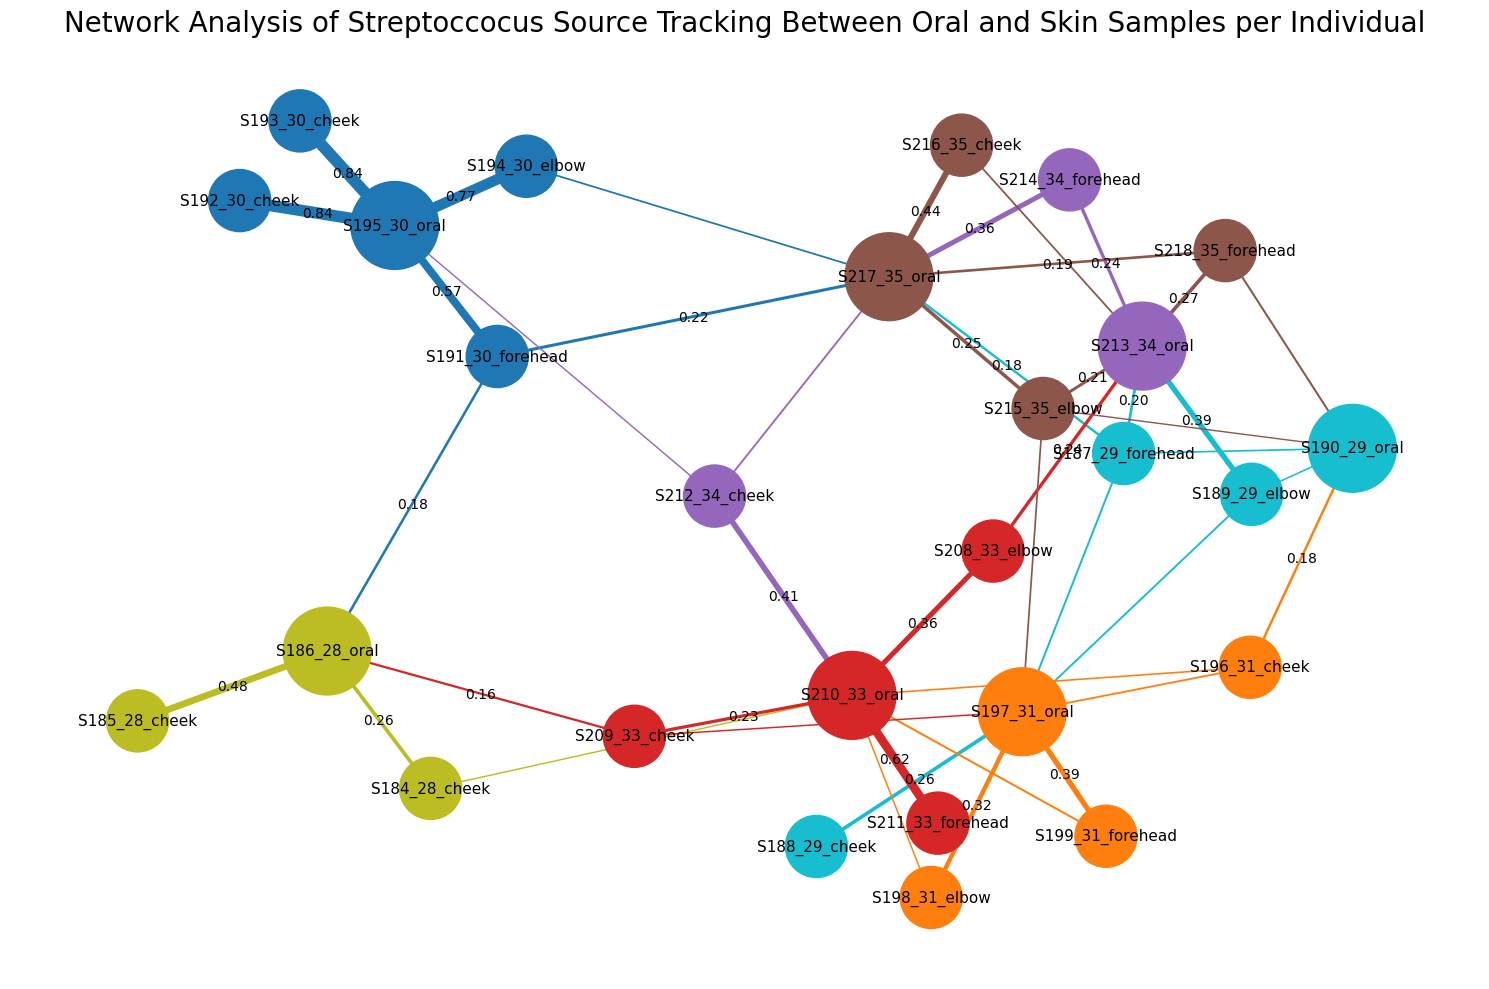

In [489]:
# Draw the network with individual-specific node colors
fig, ax = plt.subplots(figsize=(15, 10))
edges = G.edges(data=True)
nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=11, cmap=plt.cm.tab10, node_size=node_sizes,
        edge_color=edge_colors,
        width=[weight['weight'] for u, v, weight in edges])  # Width by weight

# Iterate over the edges to display weights conditionally
for (u, v, d) in G.edges(data=True):
    weight = d.get('weight', 0) / 10 # Get the weight of the edge, dividing by 10 to get back to proportion out of 1
    if weight > 0.15:  # Check if the weight is greater than 0.33
        # Calculate the midpoint of the edge to place the text
        x_mid = (pos[u][0] + pos[v][0]) / 2
        y_mid = (pos[u][1] + pos[v][1]) / 2
        # Place the text (weight) on the plot
        weight_text = f"{weight:.2f}"
        ax.text(x_mid, y_mid, s=weight_text, horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')

# Plot the figure
ax.set_title("Network Analysis of Streptoccocus Source Tracking Between Oral and Skin Samples per Individual", fontsize=20)
plt.tight_layout() 

# Save the plot as a PNG file
plt.savefig("../plots/network_plot.png", bbox_inches='tight')
